In [3]:
import pymc3 as pm
import numpy as np
import theano

from theano.compile.ops import as_op

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("/home/daniel/thesis/thesis-style.mpl")

In [4]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [24]:
def background_rate_f(b, T, n):
    """
    
    """
    out = 0
    #n = int(n)
    for i in range(n+1):
        out += ((b*T)**i * np.exp(- b*T)) / np.math.factorial(i)
    return out

def log_background_rate(b, T, n):
    return np.log(background_rate_f(b, T, n))

def signal_rate_part(s, n, b, T):
    top_a = T * ((s + b) * T)**n 
    top_b = np.exp(-(s + b)*T)
    p = (top_a * top_b) / np.math.factorial(n)
    return theano.tensor.switch(theano.tensor.le(s, 0), 0, p)

#@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dscalar])
def log_signal_rate(s,n,b,T):
    #if theano.tensor.lt(0, s): return np.array([[0.0]])
    p = -log_background_rate(b,T,n) + np.log(signal_rate_part(s,n,b,T))
    
    return p

In [25]:
def number_mweg(horizon):
    return 4./3 * np.pi * horizon**3 *(2.26)**-3* (0.0116) #* horizon**3

In [209]:
np.exp(log_signal_rate(8.6, 0, 0.01, 0.21).eval()) * number_mweg(78)

68.926868752536478

In [105]:
np.log(10)-np.log(1)-np.log(1-np.cos(np.deg2rad(30))) - np.log(number_mweg(80))

-3.3629570711216168

In [75]:
np.cos?

In [26]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform, Normal
from pymc3 import Model
from pymc3 import distributions

def grb_model(number_events, background_rate, 
              observation_time, horizon, grb_rate,
             efficiency_prior = "uniform"):
    with Model() as model:
        signal_rate = pm.DensityDist('signal_rate', 
                            logp=lambda value: log_signal_rate(value, number_events, background_rate, observation_time),
                           testval=50)

        n_galaxy = number_mweg(horizon)
    
        cbc_rate = pm.Deterministic('cbc_rate', signal_rate * n_galaxy)
        
        # Allow the efficiency prior to be switched-out
        if efficiency_prior == "uniform":
            efficiency = pm.Uniform('efficiency', 0,1)
        elif efficiency_prior == "jeffreys":
            efficiency = pm.Beta('efficiency', 0.5, 0.5)
        elif isinstance(efficiency_prior, float):
            efficiency = efficiency_prior
        
        def cosangle(cbc_rate, efficiency, grb_rate):
            return T.switch((grb_rate >= cbc_rate*efficiency), -np.Inf, 
                                 (1.0 - ((grb_rate/(cbc_rate*efficiency)))))
        
        costheta = pm.Deterministic('cos_angle', cosangle(cbc_rate, efficiency, grb_rate)
                                    
                                    )

        angle = pm.Deterministic("angle", theano.tensor.arccos(costheta))
        
        return model



In [27]:
priors = ["uniform", "jeffreys", 1.0, 0.5]

In [28]:
# 2015 - 2016 Scenario
number_events = 0 # There were no BNS detections in O1
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 46.1/365. # The number of days of analysis conducted by gstLAL
horizon = 73.2  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
o1_models = []
for prior in priors:
    o1_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [29]:
# 2016-2017 Scenarios
number_events = 1 # Assume O2 will see one BNS observation
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 0.5 # The number of years of analysis conducted 
duty_cycle = 0.5
observation_time *= duty_cycle
horizon = 80.0  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
o2_models = []
for prior in priors:
    o2_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [30]:
# 2017-2018 Scenarios
number_events = 3 # Assume O2 will see one BNS observation
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 0.75 # The number of years of analysis conducted 
duty_cycle = 0.5
observation_time *= duty_cycle
horizon = 145.0  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
o3_models = []
for prior in priors:
    o3_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [31]:
# 2019+ Scenarios
number_events = 10 # Assume O2 will see one BNS observation
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 1.0 # The number of years of analysis conducted 
duty_cycle = 0.5
observation_time *= duty_cycle
horizon = 200.0  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
o4_models = []
for prior in priors:
    o4_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [33]:
# 2022+ Scenarios
number_events = 20 # Assume O2 will see one BNS observation
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 1.0 # The number of years of analysis conducted 
duty_cycle = 0.5
observation_time *= duty_cycle
horizon = 200.0  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
o5_models = []
for prior in priors:
    o5_models.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [34]:
samples = 1000000

In [35]:
o1_traces = []
for model in o1_models:
    with model:
        step = pm.Metropolis()
        o1_traces.append(pm.sample(samples, step))
    
o2_traces = []    
for model in o2_models:
    with model:
        step = pm.Metropolis()
        o2_traces.append(pm.sample(samples, step))
        
o3_traces = []
for model in o3_models:
    with model:
        step = pm.Metropolis()
        o3_traces.append(pm.sample(samples, step))
    
o4_traces = []    
for model in o4_models:
    with model:
        step = pm.Metropolis()
        o4_traces.append(pm.sample(samples, step))
        
o5_traces = []    
for model in o5_models:
    with model:
        step = pm.Metropolis()
        o5_traces.append(pm.sample(samples, step))

100%|██████████| 1000000/1000000 [01:20<00:00, 12372.13it/s]


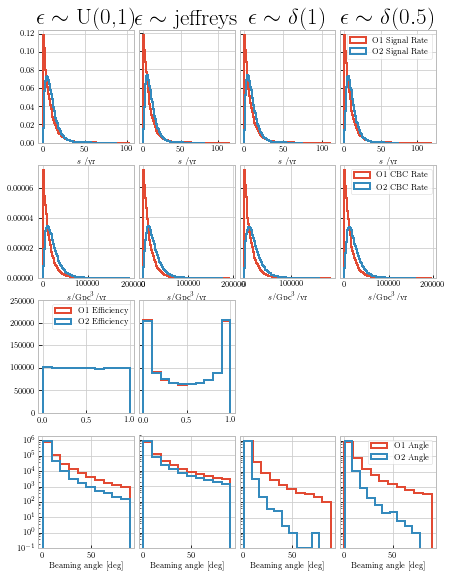

In [11]:
priors = ["U(0,1)", "jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
f, ax = plt.subplots(4,len(priors), figsize = (6, 8))
for i in range(len(priors)):

    o1_trace = o1_traces[i]
    o2_trace = o2_traces[i]

    ax[0,i].hist(o1_trace[2000:]['signal_rate'], histtype="step", label="O1 Signal Rate",
                 lw=2, normed=True, bins=100);
    ax[0,i].hist(o2_trace[2000:]['signal_rate'], histtype="step", label="O2 Signal Rate",
                 lw=2, normed=True, bins=100);
    #ax[0,0].vlines(np.percentile(trace['signal_rate'][2000:], 90), 0, 0.085,
    #              label = "90% lower limit");
    ax[0,i].set_title("$\epsilon \sim$ {}".format(priors[i]));
    ax[0,i].set_xlabel("$s$ /yr")
    if i==3:ax[0,i].legend()

    ax[1,i].hist(o1_trace[2000:]['cbc_rate'], histtype="step", lw=2, bins=100,
                 normed=True, label="O1 CBC Rate");
    ax[1,i].hist(o2_trace[2000:]['cbc_rate'], histtype="step", lw=2, bins=100,
                 normed=True, label="O2 CBC Rate");
    ax[1,i].set_xlabel(u"$s \mathrm{/Gpc}^3\mathrm{/yr}$");
    #ax[1,0].vlines(np.percentile(o1_trace['cbc_rate'][2000:], 90), 0, 5e-5,
    #              label = "90% lower limit, O1");
    #ax[1,0].vlines(np.percentile(o2_trace['cbc_rate'][2000:], 90), 0, 5e-5,
    #              label = "90% lower limit, O2", color="orange");
    if i==3:ax[1,i].legend()
    try:
        ax[2,i].hist(o1_trace[2000:]['efficiency'], histtype="step", lw=2, label="O1 Efficiency");
        ax[2,i].hist(o2_trace[2000:]['efficiency'], histtype="step", lw=2, label="O2 Efficiency");
        #ax[1,0].set_xlabel(u"$s$ /Gpc³/yr")
        if i==0: ax[2,i].legend()
        ax[2,i].set_ylim(0,2.5e5)
    except KeyError:
            ax[2,i].spines['top'].set_visible(False)
            ax[2,i].spines['bottom'].set_visible(False)
            ax[2,i].spines['left'].set_visible(False)
            ax[2,i].spines['right'].set_visible(False)
            ax[2,i].grid(False)
            ax[2,i].set_yticklabels([])
            ax[2,i].set_xticklabels([])
            ax[2,i].yaxis.set_ticks_position('none')
            ax[2,i].xaxis.set_ticks_position('none')

    ax[3,i].hist(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]),
               histtype="step", lw=2, label="O1 Angle", log=True);
    ax[3,i].hist(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]),
               histtype="step", lw=2, label="O2 Angle", log=True);
    #ax[3,i].vlines(np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 90), 0, 3e5,
    #              label = "90\% lower limit, O1");
    #ax[3,i].vlines(np.percentile(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]), 90), 0, 3e5,
    #              label = "90\% lower limit, O2");
    #ax[1,0].set_xlabel(u"$s$ /Gpc³/yr")
    if i==3: ax[3,i].legend()
    if i > 0: 
        ax[3,i].set_yticklabels([]), ax[2,i].set_yticklabels([])
        ax[0,i].set_yticklabels([]), ax[1,i].set_yticklabels([])
    ax[3,i].set_xlabel("Beaming angle [deg]")    
f.subplots_adjust(0.07, 0.05, .99, .95, wspace=0.05)
f.savefig("/home/daniel/papers/thesis/figures/grbbeamingpymc.pdf")

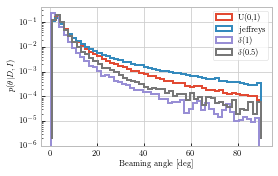

In [12]:
priors = ["U(0,1)", "jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
width = 3.487 #* 2
height = width / 1.618
f, ax = plt.subplots(1,1, figsize = (width, height), sharey=True, sharex=True)
for i in range(len(priors)):

    o1_trace = o1_traces[i]
    o2_trace = o2_traces[i]
    ax.hist(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]),
               histtype="step", bins = 50, lw=2, label=priors[i], log=True, normed=True);
    #ax.hist(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]),
    #           histtype="step", lw=2, label="O2 Angle", log=True);
    #ax[3,i].vlines(np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 90), 0, 3e5,
    #              label = "90\% lower limit, O1");
    #ax[3,i].vlines(np.percentile(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]), 90), 0, 3e5,
    #              label = "90\% lower limit, O2");
    #ax[1,0].set_xlabel(u"$s$ /Gpc³/yr")
    if i==3: ax.legend()
    #if i > 0: 
    #    ax[i].set_yticklabels([]), ax[2,i].set_yticklabels([])
    #    ax[i].set_yticklabels([]), ax[1,i].set_yticklabels([])
ax.set_xlabel("Beaming angle [deg]")    
ax.set_ylabel(r"$p(\theta | D,I)$")
f.subplots_adjust(0.07, 0.05, .99, .95, wspace=0.05)
f.savefig("O1_beaming_posteriors.pdf")
#f.savefig("/home/daniel/papers/thesis/figures/grbbeamingpymc.pdf")

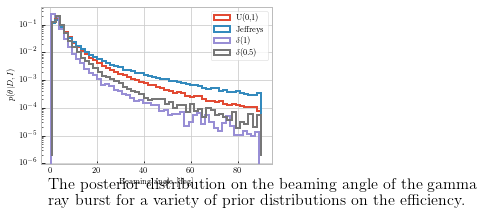

In [13]:
priors = ["U(0,1)", "Jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
width = 3.487 #* 2
height = width / 1.618 + .75
f, ax = plt.subplots(1,1, figsize = (width, height), sharey=True, sharex=True)
for i in range(len(priors)):

    o1_trace = o1_traces[i]
    o2_trace = o2_traces[i]
    ax.hist(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]),
               histtype="step", bins = 50, lw=2, label=priors[i], log=True, normed=True);
    #ax.hist(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]),
    #           histtype="step", lw=2, label="O2 Angle", log=True);
    #ax[3,i].vlines(np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 90), 0, 3e5,
    #              label = "90\% lower limit, O1");
    #ax[3,i].vlines(np.percentile(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]), 90), 0, 3e5,
    #              label = "90\% lower limit, O2");
    #ax[1,0].set_xlabel(u"$s$ /Gpc³/yr")
    if i==3: ax.legend()
    #if i > 0: 
    #    ax[i].set_yticklabels([]), ax[2,i].set_yticklabels([])
    #    ax[i].set_yticklabels([]), ax[1,i].set_yticklabels([])
ax.set_xlabel("Beaming angle [deg]")    
ax.set_ylabel(r"$p(\theta | D,I)$")
f.subplots_adjust(0.07, 0.2, .99, .95, wspace=0.05)
f.savefig("O1_beaming_posteriors_withcaption.png")
#f.savefig("/home/daniel/papers/thesis/figures/grbbeamingpymc.pdf")

txt  ="""The posterior distribution on the beaming angle of the gamma 
ray burst for a variety of prior distributions on the efficiency."""
f.text(.1,.00,txt)

In [14]:
import matplotlib

|Scenario|Lower	|MAP	|Median	|Upper	|
| 0 | 0.20	 | 0.00	 | 5.48	 | 29.42	 |
| 1 | 0.96	 | 4.03	 | 6.70	 | 22.40	 |
| 2 | 2.90	 | 7.36	 | 9.80	 | 23.39	 |
| 3 | 11.00	 | 19.59	 | 21.33	 | 36.75	 |
| 4 | 26.05	 | 40.92	 | 41.31	 | 61.73	 |


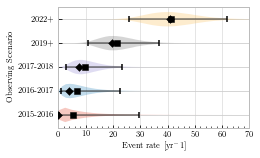

In [368]:
width = 3.487 #* 2
height = width / 1.618


f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))
priors = ["U(0,1)", "Jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
print "|Scenario|Lower\t|MAP\t|Median\t|Upper\t|"

pos = [.5, 1, 1.5, 2, 2.5]

i = 0


for i, trace in enumerate([o1_traces, o2_traces, o3_traces, o4_traces, o5_traces]):
    #i = i/2.0
    data = trace[0][2000:]['signal_rate']

    parts = ax.violinplot(data, [pos[i]], points=50, widths=0.3, vert= False,
                     #showmeans = True, showmedians=True, 
                      showmeans=False, showextrema=False, showmedians=False)

    lower, medians, upper = np.percentile(data, [2.5, 50, 97.50])
    hist = np.histogram(data, bins = 50)
    MAP = hist[1][np.argmax(hist[0])]



    ax.hlines(pos[i], lower, upper, color='#333333', linestyle='-', lw=2, alpha = 0.5)

    ax.scatter( [lower, upper], [pos[i]]*2, marker='|', color='k', s=30, zorder=3)
    ax.scatter( [MAP], pos[i], marker='D', color='k', s=30, zorder=3)
    ax.scatter( [medians], pos[i], marker='s', color='k', s=30, zorder=3)
    #ax2.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

    print "| {} | {:.2f}\t | {:.2f}\t | {:.2f}\t | {:.2f}\t |".format(i, lower, MAP, medians, upper)


axis = ax
axis.set_yticks(pos)
axis.set_yticklabels(["2015-2016", "2016-2017", "2017-2018", "2019+", "2022+"])
axis.set_xlim([0, 70])
ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.grid(b=True, axis="x", which='major', linewidth=0.5)
#ax.grid(b=True, which='minor', linewidth=0.5)
ax.set_xlabel(r"Event rate [yr$^-1$]")
ax.set_ylabel(r"Observing Scenario")
f.subplots_adjust(0.21, 0.17, .97, .95, wspace=0.05)
f.savefig("rate_posteriors_violin.pdf")

|Lower	|MAP	|Median	|Upper	|
| 1.47	 | 2.40	 | 4.31	 | 30.83	 |
| 1.40	 | 2.47	 | 4.53	 | 46.80	 |
| 1.17	 | 0.62	 | 2.70	 | 13.92	 |
| 1.64	 | 2.67	 | 3.81	 | 19.41	 |


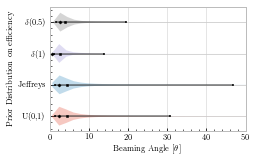

In [52]:
width = 3.487 #* 2
height = width / 1.618


f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))
priors = ["U(0,1)", "Jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
print "|Lower\t|MAP\t|Median\t|Upper\t|"
matplotlib.rcParams.update({'font.size': 10})
pos = [.5, 1, 1.5, 2]

for i in range(len(priors)):

    o1_trace = o1_traces[i]
    o2_trace = o2_traces[i]

    #i = i/2.0
    data = np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])])

    parts = ax.violinplot(data, [pos[i]], points=50, widths=0.3, vert= False,
                     #showmeans = True, showmedians=True, 
                      showmeans=False, showextrema=False, showmedians=False)

    lower, medians, upper = np.percentile(data, [2.5, 50, 97.50])
    hist = np.histogram(data, bins = 50)
    MAP = hist[1][np.argmax(hist[0])]
    
    
    
    ax.hlines(pos[i], lower, upper, color='#333333', linestyle='-', lw=2, alpha = 0.5)
    
    ax.scatter( [lower, upper], [pos[i]]*2, marker='|', color='k', s=5, zorder=3)
    ax.scatter( [MAP], pos[i], marker='D', color='k', s=5, zorder=3)
    ax.scatter( [medians], pos[i], marker='s', color='k', s=5, zorder=3)
    #ax2.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
    
    print "| {:.2f}\t | {:.2f}\t | {:.2f}\t | {:.2f}\t |".format(lower, MAP, medians, upper)
    
    axis = ax
    axis.set_yticks(pos)
    axis.set_yticklabels(priors)
    axis.set_xlim([0, 50])
    ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.grid(b=True, axis='x', which='major', linewidth=0.5)
    #ax.grid(b=True, which='minor', linewidth=0.5)
ax.set_xlabel(r"Beaming Angle [$\theta$]")
ax.set_ylabel(r"Prior Distribution on efficiency")
f.subplots_adjust(0.20, 0.15, .98, .95, wspace=0.05)
f.savefig("O1_beaming_posteriors_violin.pdf")

|Lower	|MAP	|Median	|Upper	|
| 1.44	 | 2.54	 | 3.32	 | 17.15	 |
| 1.37	 | 0.73	 | 3.42	 | 36.49	 |
| 1.17	 | 0.72	 | 2.13	 | 5.65	 |
| 1.65	 | 2.62	 | 3.01	 | 7.94	 |


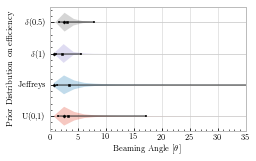

In [51]:
width = 3.487 #* 2
height = width / 1.618


f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))
priors = ["U(0,1)", "Jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
print "|Lower\t|MAP\t|Median\t|Upper\t|"

pos = [.5, 1, 1.5, 2]

for i in range(len(priors)):

    o1_trace = o1_traces[i]
    o2_trace = o2_traces[i]

    #i = i/2.0
    data = np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])])

    parts = ax.violinplot(data, [pos[i]], points=50, widths=0.3, vert= False,
                     #showmeans = True, showmedians=True, 
                      showmeans=False, showextrema=False, showmedians=False)

    lower, medians, upper = np.percentile(data, [2.5, 50, 97.50])
    hist = np.histogram(data, bins = 50)
    MAP = hist[1][np.argmax(hist[0])]
    
    
    
    ax.hlines(pos[i], lower, upper, color='#333333', linestyle='-', lw=2, alpha = 0.5)
    
    ax.scatter( [lower, upper], [pos[i]]*2, marker='|', color='k', s=5, zorder=3)
    ax.scatter( [MAP], pos[i], marker='D', color='k', s=5, zorder=3)
    ax.scatter( [medians], pos[i], marker='s', color='k', s=5, zorder=3)
    #ax2.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
    
    print "| {:.2f}\t | {:.2f}\t | {:.2f}\t | {:.2f}\t |".format(lower, MAP, medians, upper)
    
    axis = ax
    axis.set_yticks(pos)
    axis.set_yticklabels(priors)
    axis.set_xlim([0, 35])
    ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.grid(b=True, axis='x', which='major', linewidth=0.5)
ax.set_xlabel(r"Beaming Angle [$\theta$]")
ax.set_ylabel(r"Prior Distribution on efficiency")
f.subplots_adjust(0.20, 0.15, .98, .95, wspace=0.05)
f.savefig("O2_beaming_posteriors_violin.pdf")

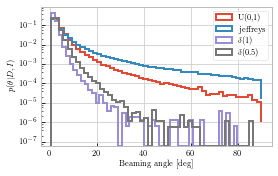

In [102]:
priors = ["U(0,1)", "jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
width = 3.487 #* 2
height = width / 1.618
f, ax = plt.subplots(1,1, figsize = (width, height), sharey=True, sharex=True)
for i in range(len(priors)):

    o1_trace = o1_traces[i]
    o2_trace = o2_traces[i]
    ax.hist(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]),
               histtype="step", bins = 50, lw=2, label=priors[i], log=True, normed=True);
    #ax.hist(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]),
    #           histtype="step", lw=2, label="O2 Angle", log=True);
    #ax[3,i].vlines(np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 90), 0, 3e5,
    #              label = "90\% lower limit, O1");
    #ax[3,i].vlines(np.percentile(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]), 90), 0, 3e5,
    #              label = "90\% lower limit, O2");
    #ax[1,0].set_xlabel(u"$s$ /Gpc³/yr")
    if i==3: ax.legend()
    #if i > 0: 
    #    ax[i].set_yticklabels([]), ax[2,i].set_yticklabels([])
    #    ax[i].set_yticklabels([]), ax[1,i].set_yticklabels([])
ax.set_xlabel("Beaming angle [deg]")    
ax.set_ylabel(r"$p(\theta | D,I)$")
f.subplots_adjust(0.07, 0.05, .99, .95, wspace=0.05)
f.savefig("O2_beaming_posteriors.pdf")
#f.savefig("/home/daniel/papers/thesis/figures/grbbeamingpymc.pdf")

In order to get an idea of what how the estimate of the opening angle changes with respect to increasing horizon distance and an increasing number of detections we can make a plot of the median value of the probability distribution for each of the different priors with respect to both these quantities.

In [11]:
# make a plot of the beaming angle as a function of observation volume against number of detections
# O1 Scenarios
scenarios = []
for events in range(10):
    for horizon in np.linspace(10, 400, 20):
        number_events = events # There were no BNS detections in O1
        background_rate = 0.01 # We take the FAR to be 1/100 yr
        observation_time = 1. # The number of days of analysis conducted by gstLAL
        horizon = horizon  # The O1 BNS horizon distance in O1 BNS paper
        grb_rate = 10.0
        prior = 1.0
        o1_models = []
        for prior in priors:
            scenarios.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, ))

In [14]:
traces = []
samples = 100000
for model in scenarios:
    with model:
        step = pm.Metropolis()
        traces.append(pm.sample(samples, step, ))



  0%|          | 0/100000 [00:00<?, ?it/s]

  1%|          | 562/100000 [00:00<00:17, 5613.38it/s]

  1%|          | 1164/100000 [00:00<00:17, 5728.66it/s]

  2%|▏         | 1755/100000 [00:00<00:16, 5780.15it/s]

  2%|▏         | 2282/100000 [00:00<00:17, 5616.62it/s]

  3%|▎         | 2742/100000 [00:00<00:18, 5264.71it/s]

  3%|▎         | 3180/100000 [00:00<00:21, 4525.79it/s]

  4%|▎         | 3589/100000 [00:00<00:23, 4149.06it/s]

  4%|▍         | 3980/100000 [00:00<00:24, 3928.92it/s]

  4%|▍         | 4425/100000 [00:00<00:23, 4071.13it/s]

  5%|▍         | 4824/100000 [00:01<00:25, 3688.30it/s]

  5%|▌         | 5194/100000 [00:01<00:27, 3446.74it/s]

  6%|▌         | 5551/100000 [00:01<00:27, 3478.12it/s]

  6%|▌         | 5966/100000 [00:01<00:25, 3654.67it/s]

  6%|▋         | 6359/100000 [00:01<00:25, 3730.79it/s]

  7%|▋         | 6736/100000 [00:01<00:25, 3709.45it/s]

  7%|▋         | 7113/100000 [00:01<00:24, 3723.38it/s]

  7%|▋         | 7487/100000 [00:01<00:25, 

In [15]:
ax[np.unravel_index([3], [2,2])][0]

NameError: name 'ax' is not defined

In [20]:
priors = ["U(0,1)", "jeffreys", "$\delta(1)$", "$\delta(0.5)$"]
from matplotlib import colors, ticker, cm

dist = 3
#f, ax = plt.subplots(2,2, figsize=(10,10))
#for dist in range(4):
angles975 = []
angles025 = []
angles500 = []
for trace in traces[dist::4]:

    angles975.append(np.nanpercentile(trace['angle'][1000:], 97.5))
    angles025.append(np.nanpercentile(trace['angle'][1000:], 2.5))
    angles500.append(np.nanpercentile(trace['angle'][1000:], 50))
#plt.figure(figsize=(10,10))
#plt.contour((np.rad2deg(angles025).reshape(-1, 20)), extent=(10, 390, 0, 9), aspect=500)

#cons = ax[np.unravel_index([dist], [2,2])][0].contourf(np.log10(np.arange(10, 400, 20)), np.arange(10), 
#             np.rad2deg(angles500).reshape(10, 20)/2, 
#             levels = np.linspace(0,90, 21)
#            )#locator=ticker.LogLocator(), )#levels=(np.logspace(-0.7, np.log(90), 10)))
#ax[np.unravel_index([dist], [2,2])][0].set_title(priors[dist])
#ax[np.unravel_index([dist], [2,2])][0].set_ylabel("Number of events")
#ax[np.unravel_index([dist], [2,2])][0].set_xlabel("log10 Horizon Distance")
#plt.colorbar(cons, label="Angle [deg]")

np.savetxt("975perc", angles975)
np.savetxt("500perc", angles500)
np.savetxt("025perc", angles025)

In [53]:
from astropy import constants as c
from astropy import units as u

scenarios = [
    #["O1", 0.5, 80],
    ["A", 0.4, 80],
    ["B", 0.5, 120],
    ["Design", 1.0, 200],
    ["BNS Opt", 1.0, 215]
]

extraticks = []
extralabels = []
for scenario in scenarios:
    years = scenario[1] * u.year
    srange = scenario[2] * u.megaparsec
    extralabels.append(scenario[0])
    extraticks.append(((c.c * years).to(u.megaparsec) * srange**3).value)


In [54]:
angles500 = np.loadtxt('500perc')

In [6]:
lowers = np.genfromtxt('lower.dat')

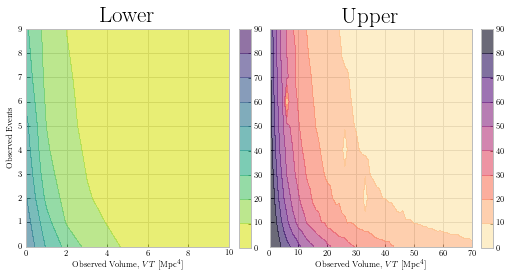

In [101]:
f, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)
lower_c = ax[0].contourf(lowers.reshape((10,200)), levels = np.linspace(0,90, 10), alpha = 0.6, cmap = 'viridis_r', linewidth=0)
cax =  f.add_axes([0.495, 0.12, 0.02, 0.76])
cbar = f.colorbar(lower_c, cax=cax, ticks=np.linspace(0,90, 10), orientation='vertical')
ax[0].set_xlim([0, 10])
ax[0].grid(b=True, which='major', linewidth=1.0)
ax[0].grid(b=True, which='minor', linewidth=0.5)
ax[0].set_xlabel(r"Observed Volume, $VT$ [Mpc$^4$]")
ax[0].set_ylabel(r"Observed Events")
ax[0].set_title("Lower ")
# ---
upper_c = ax[1].contourf(uppers.reshape((10,200)), alpha = 0.6, levels = np.linspace(0,90, 10),)
cax =  f.add_axes([0.915, 0.12, 0.02, 0.76])
cbar = f.colorbar(upper_c, cax=cax, ticks=np.linspace(0,90, 10), orientation='vertical')
ax[1].set_xlim([0, 70])
ax[1].grid(b=True, which='major', linewidth=1.0)
ax[1].grid(b=True, which='minor', linewidth=0.5)
ax[1].set_xlabel(r"Observed Volume, $VT$ [Mpc$^4$]")
ax[1].set_ylabel(r"")
ax[1].set_title("Upper ")

#f.tight_layout()

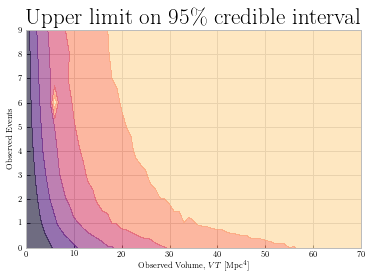

In [35]:
uppers = np.genfromtxt('upper.dat')
f, ax = plt.subplots(1,1)
ax.contourf(uppers.reshape((10,200)), alpha = 0.6, )
ax.set_xlim([0, 70])
ax.grid(b=True, which='major', linewidth=1.0)
ax.grid(b=True, which='minor', linewidth=0.5)
ax.set_xlabel(r"Observed Volume, $VT$ [Mpc$^4$]")
ax.set_ylabel(r"Observed Events")
ax.set_title("Upper limit on 95\% credible interval")

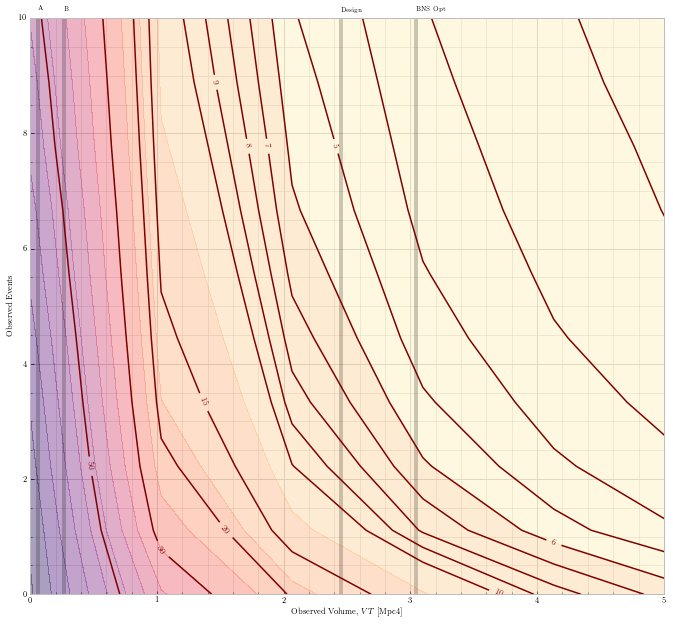

In [56]:
import scipy.ndimage
data = scipy.ndimage.zoom(np.rad2deg(angles500).reshape(10, 20), 1)

width = 3.487 #* 2
height = width / 1.618

matplotlib.rcParams.update({'font.size': 6})


height, width= 10, 10
f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))



ax.set_xlim([0, 5.0]);

vth = (c.c * 1*u.year).to(u.megaparsec)
for i in xrange(len(extraticks)):
    ax.vlines(extraticks[i], 0, 10, color='k', alpha=0.2, lw=4)
    x_bounds = ax.get_xlim()
    ax.annotate(s=extralabels[i], xy =((extraticks[i]/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', verticalalignment='right', horizontalalignment='center bottom' , rotation = 0)

consf = ax.contourf(np.linspace(vth*10**3, vth*400**3, data.shape[1]), np.linspace(0, 10, data.shape[0]), 
             data, 
             levels = np.linspace(0,90, 16), alpha = 0.4, cmap = "magma_r", lw=0
            )

cons = ax.contour(np.linspace(vth*10**3, vth*400**3, data.shape[1]), np.linspace(0, 10, data.shape[0]), 
             data, 
             levels = [0,1,2,3,4,5,6,7,8,9,10, 15, 20, 30, 50], colors='maroon', lw=2, cw=1
            )

#cons = ax.contour(np.log10(data))

ax.clabel(cons, inline=1, fontsize=8, fmt='%1.0f')

ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', linewidth=1.0)
ax.grid(b=True, which='minor', linewidth=0.5)

ax.set_xlabel(r"Observed Volume, $VT$ [Mpc4]")
ax.set_ylabel(r"Observed Events")
f.subplots_adjust(0.1, 0.15, .98, .95, wspace=0.05)
f.savefig("volume_v_nevents.pdf")

# Reverse test

As a sanity check of the results, we can calculate the number of GRBs we would expect to observe for a range of different beaming angles. We can then compare this to predicted beaming angle for an analysis in which the GRB rate is set to the our expected number of detections.

In [306]:
detections = []
for beamangle in np.linspace(0, 90, 90):
    beamangle = np.deg2rad(beamangle)
    costheta = np.random.uniform(0,1, 10000)
    theta = np.arccos(costheta)
    detections.append(np.count_nonzero(theta<beamangle))

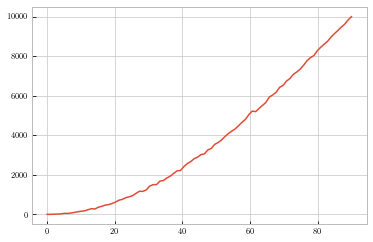

In [307]:
plt.plot(np.linspace(0,90,90), detections)

In [308]:
test_scenarios = []
for grbs in np.arange(1, 10):
    # O1 Scenarios
    events = 10.  
    number_events = int(events) # There were no BNS detections in O1
    background_rate = 0.01#0.01 # We take the FAR to be 1/100 yr
    observation_time = 1#46.1/365. # The number of days of analysis conducted by gstLAL
    horizon = 6.195#73.2  # The O1 BNS horizon distance in O1 BNS paper
    grb_rate = grbs
    o1_models = []
    test_scenarios.append(grb_model(number_events, background_rate, observation_time, horizon, grb_rate, 1.0))

In [310]:
samples = 50000
angles = []
for test_model in test_scenarios:
    with test_model as model:
            step = pm.Metropolis()
            trace = pm.sample(samples, step)
            angles.append(np.rad2deg(np.nanmean(trace['angle'])))

100%|██████████| 50000/50000 [00:03<00:00, 14124.41it/s]


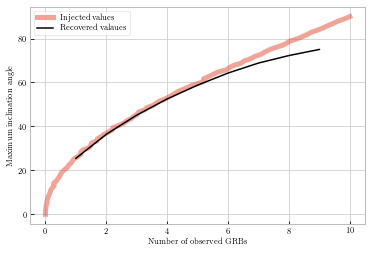

In [311]:
plt.plot(np.array(detections)/1000.0, np.linspace(0,90,90), lw=5, alpha=0.5, label="Injected values")
plt.plot(np.arange(1,10), angles, label="Recovered valaues", color="k")
plt.xlabel("Number of observed GRBs")
plt.ylabel("Maximum inclination angle")
plt.legend()

# Injection Tests

## O1-like scenario

In [361]:
test_scenarios = []
priors = ["uniform", "jeffreys", 0.5]
for prior in priors:
    # O1 Scenarios
    number_events = 0 # There were no BNS detections in O1
    background_rate = 0.01 # We take the FAR to be 1/100 yr
    observation_time = 46.1/365. # The number of days of analysis conducted by gstLAL
    horizon = 73.2  # The O1 BNS horizon distance in O1 BNS paper
    grb_rate = 100
    o1_models = []
    test_scenarios.append(grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [362]:
samples = 50000
traces = []
for test_model in test_scenarios:
    with test_model as model:
            step = pm.Metropolis()
            traces.append( pm.sample(samples, step) )
            angles.append(np.rad2deg(np.nanmean(trace['angle'])))

100%|██████████| 50000/50000 [00:03<00:00, 12527.33it/s]


| 4.66	 | 7.70	 | 13.34	 | 63.50	 |
| 4.37	 | 5.81	 | 13.14	 | 68.62	 |
| 5.24	 | 6.42	 | 12.01	 | 51.30	 |


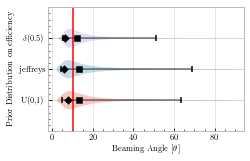

In [363]:
width = 3.487 #* 2
height = width / 1.618


f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))
priors = ["U(0,1)", "jeffreys", "$\delta(0.5)$"]
pos = np.arange(4)/2.
cbc_rate = np.mean(traces[0]['cbc_rate'])
injected = np.arccos(1 - 2*grb_rate / cbc_rate)
ax.vlines(np.rad2deg(injected), -0.5,2, 'r')
for i, trace in enumerate(traces):
    data = np.rad2deg(trace[2000:]['angle'][np.isfinite(trace[2000:]['angle'])])
    parts = ax.violinplot(data, 
                          [pos[i]], points=50, widths=0.3, vert= False,
                     #showmeans = True, showmedians=True, 
                      showmeans=False, showextrema=False, showmedians=False)

    lower, medians, upper = np.percentile(data, [2.5, 50, 97.50])
    hist = np.histogram(data, bins = 50)
    MAP = hist[1][np.argmax(hist[0])]

    
    

    ax.hlines(pos[i], lower, upper, color='#333333', linestyle='-', lw=2, alpha = 0.5)

    ax.scatter( [lower, upper], [pos[i]]*2, marker='|', color='k', s=30, zorder=3)
    ax.scatter( [MAP], pos[i], marker='D', color='k', s=30, zorder=3)
    ax.scatter( [medians], pos[i], marker='s', color='k', s=30, zorder=3)
    print "| {:.2f}\t | {:.2f}\t | {:.2f}\t | {:.2f}\t |".format(lower, MAP, medians, upper)
    axis = ax
    axis.set_yticks(pos)
    axis.set_yticklabels(priors)
    ax.set_ylim(-0.5, 1.5)
    ax.grid(b=True, axis='x', which='major', linewidth=0.5)
    #axis.set_xlim([0, 35])
    ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    
ax.set_xlabel(r"Beaming Angle [$\theta$]")
ax.set_ylabel(r"Prior Distribution on efficiency")
f.subplots_adjust(0.20, 0.15, .98, .95, wspace=0.05)
f.savefig("O1_injections_violin.pdf")

## O2-like scenario

In [364]:
test_scenarios = []
priors = ["uniform", "jeffreys", 0.5]
for prior in priors:
    # O1 Scenarios
    grb_rate = 100
    number_events = 1 # Assume O2 will see one BNS observation
    background_rate = 0.01 # We take the FAR to be 1/100 yr
    observation_time = 0.5 # The number of years of analysis conducted 
    duty_cycle = 0.5
    observation_time *= duty_cycle
    horizon = 80.0  # The O1 BNS horizon distance in O1 BNS paper
    
    test_scenarios.append(grb_model(number_events, background_rate, observation_time, horizon, grb_rate, prior))

In [365]:
samples = 50000
traces = []
for test_model in test_scenarios:
    with test_model as model:
            step = pm.Metropolis()
            traces.append( pm.sample(samples, step) )
            angles.append(np.rad2deg(np.nanmean(trace['angle'])))

100%|██████████| 50000/50000 [00:03<00:00, 13538.34it/s]


| 4.53	 | 6.17	 | 10.50	 | 47.80	 |
| 4.28	 | 5.91	 | 10.17	 | 61.90	 |
| 5.22	 | 6.97	 | 9.47	 | 26.01	 |


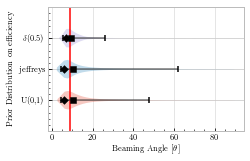

In [366]:
width = 3.487 #* 2
height = width / 1.618


f, ax = plt.subplots(1,1, sharex=True, figsize = (width, height))
priors = ["U(0,1)", "jeffreys", "$\delta(0.5)$"]
pos = np.arange(4)/2.
cbc_rate = np.mean(traces[0]['cbc_rate'])
injected = np.arccos(1 - 2*grb_rate / cbc_rate)
ax.vlines(np.rad2deg(injected), -0.5,2, 'r')
for i, trace in enumerate(traces):
    data = np.rad2deg(trace[2000:]['angle'][np.isfinite(trace[2000:]['angle'])])
    parts = ax.violinplot(data, 
                          [pos[i]], points=50, widths=0.3, vert= False,
                     #showmeans = True, showmedians=True, 
                      showmeans=False, showextrema=False, showmedians=False)

    lower, medians, upper = np.percentile(data, [2.5, 50, 97.50])
    hist = np.histogram(data, bins = 50)
    MAP = hist[1][np.argmax(hist[0])]

    
    

    ax.hlines(pos[i], lower, upper, color='#333333', linestyle='-', lw=2, alpha = 0.5)

    ax.scatter( [lower, upper], [pos[i]]*2, marker='|', color='k', s=30, zorder=3)
    ax.scatter( [MAP], pos[i], marker='D', color='k', s=30, zorder=3)
    ax.scatter( [medians], pos[i], marker='s', color='k', s=30, zorder=3)
    print "| {:.2f}\t | {:.2f}\t | {:.2f}\t | {:.2f}\t |".format(lower, MAP, medians, upper)
    axis = ax
    axis.set_yticks(pos)
    axis.set_yticklabels(priors)
    ax.set_ylim(-0.5, 1.5)
    ax.grid(b=True, axis='x', which='major', linewidth=0.5)
    #axis.set_xlim([0, 35])
    ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.set_xlabel(r"Beaming Angle [$\theta$]")
ax.set_ylabel(r"Prior Distribution on efficiency")
f.subplots_adjust(0.20, 0.15, .98, .95, wspace=0.05)
f.savefig("O2_injections_violin.pdf")

# Effect of observing time and horizon distance on the posterior

In [286]:
# make a plot of the beaming angle as a function of observation volume against number of detections
# O1 Scenarios
scenarios = []
events = 0
for horizon in np.arange(10, 400, 20):
    number_events = events # There were no BNS detections in O1
    background_rate = 0.01 # We take the FAR to be 1/100 yr
    observation_time = 1. # The number of days of analysis conducted by gstLAL
    horizon = horizon  # The O1 BNS horizon distance in O1 BNS paper
    grb_rate = 10.0
    prior = 1.0
    zero_models = []
    for prior in priors:
        scenarios.append( grb_model(number_events, background_rate, observation_time, horizon, grb_rate, ))

In [287]:
traces = []
samples = 10000
for model in scenarios:
    with model:
        step = pm.Metropolis()
        traces.append(pm.sample(samples, step))

100%|██████████| 10000/10000 [00:01<00:00, 6160.08it/s]


In [291]:
angles = []
upper = []
lower = []
for trace in traces:
    angles.append(np.rad2deg(np.nanmean(trace['angle'])))
    upper.append(np.rad2deg(np.nanpercentile(trace['angle'], 97.5)))
    lower.append(np.rad2deg(np.nanpercentile(trace['angle'], 2.5)))

For a scenario in which there are no detections, the estimate of the beaming angle against the horizon distance can be produced.

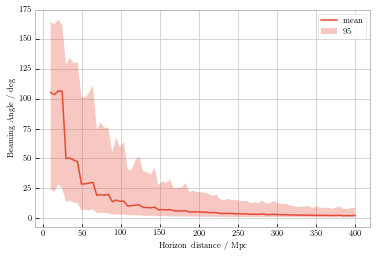

In [310]:
plt.plot(np.linspace(10, 400, len(traces)),angles, label = "mean")
plt.fill_between(np.linspace(10, 400, len(traces)), upper, lower, alpha = 0.3, label = "95% confidence interval")
plt.legend()
plt.xlabel("Horizon distance / Mpc")
plt.ylabel("Beaming Angle / deg")

In [250]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform, Normal
from pymc3 import Model
from pymc3 import distributions

priors = ["uniform", "jeffreys", 1.0, 0.5]
theta = np.deg2rad(30)

def grb_model_reverse(number_events, background_rate, 
              observation_time, horizon,
             efficiency_prior = "uniform"):
    with Model() as model:
        signal_rate = pm.Deterministic("signal_rate", log_signal_rate(value, number_events, background_rate, observation_time)
                                      )
        n_galaxy = number_mweg(horizon)
        
        cbc_rate = pm.Deterministic('cbc_rate', signal_rate * n_galaxy)
        
        
        # Allow the efficiency prior to be switched-out
        if efficiency_prior == "uniform":
            efficiency = pm.Uniform('efficiency', 0,1)
        elif efficiency_prior == "jeffreys":
            efficiency = pm.Beta('efficiency', 0.5, 0.5)
        elif isinstance(efficiency_prior, float):
            efficiency = efficiency_prior
        
        grb_rate = 3.0
        print grb_rate
        
        def cosangle(cbc_rate, efficiency, grb_rate):
            return T.switch((grb_rate >= cbc_rate*efficiency), -np.Inf, 
                                 (1.0 - ((grb_rate/(cbc_rate*efficiency)))))
        
        costheta = pm.Deterministic('cos_angle', cosangle(cbc_rate, efficiency, grb_rate)
                                    
                                    )

        angle = pm.Deterministic("angle", theano.tensor.arccos(costheta))
        
        return model

In [251]:
# 2015 - 2016 Scenario
number_events = 0 # There were no BNS detections in O1
background_rate = 0.01 # We take the FAR to be 1/100 yr
observation_time = 46.1/365. # The number of days of analysis conducted by gstLAL
horizon = 73.2  # The O1 BNS horizon distance in O1 BNS paper
grb_rate = 10.0
back_models = []
for prior in priors:
    back_models.append( grb_model_reverse(number_events, background_rate, observation_time, horizon, prior))

3.0
3.0
3.0
3.0


In [252]:
back_traces = []
samples = 10000
for model in back_models:
    with model:
        step = pm.Metropolis()
        back_traces.append(pm.sample(samples, step))

100%|██████████| 10000/10000 [00:01<00:00, 9846.84it/s]


ValueError: need at least one array to concatenate

In [253]:
priors = ["U(0,1)", "jeffreys",]# "$\delta(1)$", "$\delta(0.5)$"]
width = 3.487 #* 2
height = width / 1.618
f, ax = plt.subplots(1,1, figsize = (width, height), sharey=True, sharex=True)
for i in range(len(priors)):

    o1_trace = back_traces[i]
    ax.hist(np.rad2deg(o1_trace[2000:]['cos_angle'][np.isfinite(o1_trace[2000:]['cos_angle'])]),
               histtype="step", bins = 50, lw=2, label=priors[i], log=True, normed=True);
    #ax.hist(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]),
    #           histtype="step", lw=2, label="O2 Angle", log=True);
    #ax[3,i].vlines(np.percentile(np.rad2deg(o1_trace[2000:]['angle'][np.isfinite(o1_trace[2000:]['angle'])]), 90), 0, 3e5,
    #              label = "90\% lower limit, O1");
    #ax[3,i].vlines(np.percentile(np.rad2deg(o2_trace[2000:]['angle'][np.isfinite(o2_trace[2000:]['angle'])]), 90), 0, 3e5,
    #              label = "90\% lower limit, O2");
    #ax[1,0].set_xlabel(u"$s$ /Gpc³/yr")
    if i==3: ax.legend()
    #if i > 0: 
    #    ax[i].set_yticklabels([]), ax[2,i].set_yticklabels([])
    #    ax[i].set_yticklabels([]), ax[1,i].set_yticklabels([])
ax.set_xlabel("Beaming angle [deg]")    
ax.set_ylabel(r"$p(\theta | D,I)$")
f.subplots_adjust(0.07, 0.05, .99, .95, wspace=0.05)
f.savefig("O1_beaming_posteriors.pdf")
#f.savefig("/home/daniel/papers/thesis/figures/grbbeamingpymc.pdf")

ValueError: zero-size array to reduction operation minimum which has no identity

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [292]:
np.mean(trace['cbc_rate'])

11.062123598063081